# Implementation of a Convolutional Neural Network (CNN) classification model with Word2Vec embeddings

Note this notbook downloads the required data from a google drive in which the data acquired from https://github.com/sebischair/Medical-Abstracts-TC-Corpus is installed.

The use of implementation within GoogleColab aso allows the user to utilise a public GPU.

## 0.1 Required packages



In [33]:
import nltk
import pickle
import pandas as pd
import requests
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
import string
from nltk.tokenize import word_tokenize
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('popular')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data

True

## 0.2 Data installations

This cell requires the user to downloads the dataset mentioned previous to a path they can input below.


In [34]:
#Installation of dataset
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
train_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_train.csv') #input own path
test_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_test.csv')
df_labels = pd.read_csv('/content/drive/MyDrive/medical_tc_labels.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.3 Device agnostic code

If running on google colab reader should set 'runtime type to GPU (graphical processing unit).

The purpose for creation of rendering images means it has faster compute time than using a CPU, as tasks are divided into much smaller parts running on a larger number of cores in parallel.

This is useful in our implementation as training a NN over multiple epochs can take time, and computational speedup is always welcomed.

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1 Preprocessing and data preparation

Analysis and derivation found in file '01_Introductin_EDA_and_preprocessing.ipynb'

In [36]:
en_stop = set(stopwords.words('english'))
def preprocess(data):
    data_proc = []
    for doc in data['medical_abstract']:
        #lowercases document
        doc = doc.lower()
        #removes any non-letter characters
        doc = re.sub(r'\b[^a-zA-Z]+\b', ' ', doc)
        #tokenize
        toks = nltk.word_tokenize(doc)
        #remove tokens of lenth <= 1 (can be varied)
        toks = [tok for tok in toks if len(tok) > 1]
        #remove stopwords
        toks = [tok for tok in toks if tok not in en_stop]
        #lemmatize
        toks = [WordNetLemmatizer().lemmatize(tok) for tok in toks]
        data_proc.append(toks)
    return data_proc

In [37]:
text_train = train_dataset['medical_abstract']
y_train = train_dataset['condition_label']
text_test = test_dataset['medical_abstract']
y_test = test_dataset['condition_label']

In [38]:
X_trains  = preprocess(train_dataset)
X_tests = preprocess(test_dataset)
#print(X_trains[0])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_trains)

X_train = tokenizer.texts_to_sequences(X_trains)
X_test = tokenizer.texts_to_sequences(X_tests)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
#print(X_train[0])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


X_train_tensor = torch.LongTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)



X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

y_test_tensor = torch.LongTensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)
test_loader = test_loader

## 2 Word2Vec

https://arxiv.org/pdf/1301.3781.pdf [3]

Word2Vec is an embedding that considers similarities of words within texts,and outputs a vectorisation representation for words within a corpus. Similarities within word2vec consider arangements and combinations within sentences and their gramatic relationship, as well as semantic similarity, that considers context based on meaning.

It is a useful technique because it allows personalisation for the user in how closely you want the relationship between words to be considered (tailored via `window`), so can be altered in context. It also is useful in the context of neural networks as the vectorisation output is easy to use as an input in the appropriate model.





### 2.1 Implementation

The cell below trains a word2vec model based on the corpus of texts provided in the training data.

In [39]:
import random
torch.manual_seed(302)
np.random.seed(302)
random.seed(302)
# Train the Word2Vec model
vocab_size = len(tokenizer.word_index) + 1
w2v_model = Word2Vec(X_trains, vector_size=100, window=5, min_count=1, workers=4)
print(w2v_model)
#w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)


# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


Word2Vec<vocab=30615, vector_size=100, alpha=0.025>
(30616, 100)


## 3 Evaluation metrics

Used in model evaluation. Note the accuracy function and timeit function are retreived from: mrdbuorke [2]

In [40]:
#Accuracy (source mrdbuorke colab link)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [41]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start adn end time. """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end= end_time, device = "cpu")

Train time on cpu: 0.000 seconds


4.386000000522472e-05

In [42]:
def performance(conf_mat):
  TP = 0
  for i in range(conf_mat.shape[0]):
    Class = df_labels['condition_name'][i]
    tp = conf_mat[i, i]
    fp = np.sum(conf_mat[:, i]) - tp
    fn = np.sum(conf_mat[i, :]) - tp
    tn = np.sum(conf_mat) - (tp + fp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    TP += tp
    print(Class.upper())
    print( f"Precision: {precision:.2f}, Recall: {recall:.2f}")
  accuracy_tot = TP / np.sum(conf_mat)
  print(f"Total Accuracy: {accuracy_tot:.3f}")
  return

## 4 CNN model

https://arxiv.org/ftp/arxiv/papers/2301/2301.11696.pdf [4]

To capture the complicated structures of sentences and texts within the english language, a robust classification model must be able to identify the intricate and varying details within a large corpora of texts. Convolution Neural Networks (CNNs) have emerged as a leading model for this task.
Their deep learning capabilities allow theidentification of  compliacated patterns within context, thus highlighting why word2vec and CNNs usually go hand-in-hand.

Our implementation of the convoluation neural network to classify the medical abstracts is drawn from the methodology outlined within this report https://arxiv.org/ftp/arxiv/papers/1704/1704.06841.pdf [5]. We use the two convoluational and max-pooling layers as specified in the report, while conducting our own parameter tuning for learning rates and kernel based on our analysis of accuracy scores.

Although the model's parameter and layer configurations are not exhaustively discussed in the `appendix.ipynb` file, leveraging structural insights from hte referenced report and parameter tuning have led us to establish a "sufficient neural network" structure in the context of our goal for classification of medical abstracts.



### 4.1 Model Architecture

In [43]:
num_classes =5
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)
#create vector of labels 0,4

class CNNMulticlass(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_length):
        super(CNNMulticlass, self).__init__()
        #Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False #keeps original embedding matrix

        #two convolutional layers and 2 max pool layers like paper[1]
        self.conv1 = nn.Conv1d(embedding_dim, 256, kernel_size=2)
        self.pool1 = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=2)
        self.pool2 = nn.MaxPool1d(5)
        #flattening for fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * ((max_length - 4) // 25) , 256)
        self.fc2 = nn.Linear(256, num_classes)
        #softmax activation for final output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      #pass input through embedding layer
        x = self.embedding(x)
        #need to rearrange for conv layer
        x = x.permute(0, 2, 1)
        #RelU activations with conv and max pool layers
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x




### 4.2 Model instantiation, training and testing

For faster implementation run on a GPU.

In [44]:
model_multiclass = CNNMulticlass(vocab_size, 100, embedding_matrix, max_length).to(device)
optimizer = torch.optim.Adam(model_multiclass.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


from tqdm.auto import tqdm
print(len(test_loader))
train_time_start_on_cpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n-----")
    train_loss = 0
    for batch, (inputs, labels) in enumerate(train_loader):
        model_multiclass.train()
        # Forward pass'=
        #print(inputs)
        y_pred = model_multiclass(inputs).to(device)
        #print(y_pred.softmax(dim=1))
        #Calculate loss
        labels = labels.long() -1
        #print(labels)
        loss = criterion(y_pred, labels)
        train_loss += loss
        #optimizer zero-grad
        optimizer.zero_grad()
        #loss backward
        loss.backward()
        #step
        optimizer.step()

    train_loss /= len(train_loader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_multiclass.eval()
    with torch.inference_mode():
        for X_test_tensor, y_test_tensor in test_loader:
            #forward pass
            test_pred = model_multiclass(X_test_tensor).to(device)
            #print(y_test_tensor -1)[0,4]
            #calculate loss
            y_test_tensor = y_test_tensor-1 #.Long()
            y_test_tensor = y_test_tensor.to(device)
            test_loss += criterion(test_pred, y_test_tensor)
            #calculate accuracy
            y_preds = test_pred.argmax(dim=1)
            #print(y_preds)
            test_acc += accuracy_fn(y_true = y_test_tensor, y_pred = y_preds)
        # Calculate the test loss average per batch
        test_loss /= len(test_loader)

        # Calculate the test acc average per batch
        test_acc /= len(test_loader)



    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    train_time_end_on_cpu = timer()
    total_train_time_model_multiclass = print_train_time(start = train_time_start_on_cpu,
                                              end = train_time_end_on_cpu,
                                              device=str(next(model_multiclass.parameters()).device))

91


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0
-----

Train loss: 1.2527 | Test loss: 1.1637, Test acc: 49.3475
Train time on cpu: 20.037 seconds
Epoch:1
-----

Train loss: 1.1152 | Test loss: 1.1021, Test acc: 53.9835
Train time on cpu: 41.701 seconds
Epoch:2
-----

Train loss: 1.0872 | Test loss: 1.0866, Test acc: 55.8036
Train time on cpu: 64.405 seconds
Epoch:3
-----

Train loss: 1.0701 | Test loss: 1.0943, Test acc: 53.0907
Train time on cpu: 90.488 seconds
Epoch:4
-----

Train loss: 1.0512 | Test loss: 1.0963, Test acc: 54.6703
Train time on cpu: 112.546 seconds
Epoch:5
-----

Train loss: 1.0451 | Test loss: 1.0723, Test acc: 56.1470
Train time on cpu: 135.160 seconds
Epoch:6
-----

Train loss: 1.0346 | Test loss: 1.0877, Test acc: 55.9409
Train time on cpu: 157.962 seconds
Epoch:7
-----

Train loss: 1.0362 | Test loss: 1.0968, Test acc: 54.9794
Train time on cpu: 179.615 seconds
Epoch:8
-----

Train loss: 1.0256 | Test loss: 1.0704, Test acc: 54.4986
Train time on cpu: 203.829 seconds
Epoch:9
-----

Train loss: 1.021

## 4.3 Model Evaluation

Making predictions...:   0%|          | 0/91 [00:00<?, ?it/s]

mlxtend version: 0.23.0
tensor([2, 4, 4,  ..., 3, 0, 3])
tensor([2, 2, 0,  ..., 3, 0, 0])


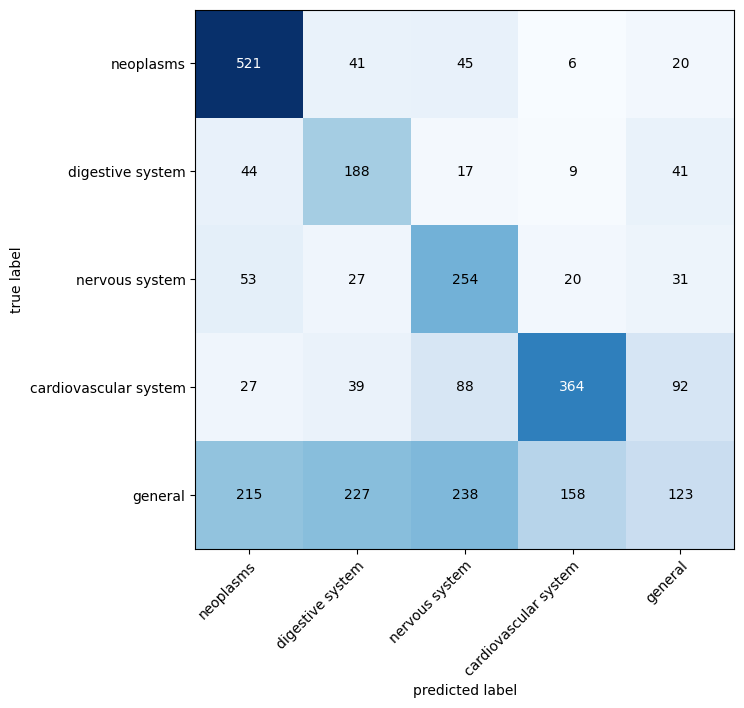

In [45]:
# Import tqdm.auto for progress bar tracking
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)

from tqdm.auto import tqdm

#1. Make predictions with trained model
y_preds = []
model_multiclass.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions..."):
    # Send the data and targets to target device
    # DO the forward pass
    X, y = X.to(device), y.to(device)

    y_logits = model_multiclass(X)
    #Turn prediction from logits -> prediction porbabilities -> prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim =0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

  #COncatenate list of predictions into a tensor
  #print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f" mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
class_names = ["neoplasms", "digestive system" , "nervous system", "cardiovascular system", "general"]



confmat = ConfusionMatrix(task = "multiclass",
                          num_classes=5)

y_test_tensor = torch.LongTensor(y_test)-1
print(y_test_tensor)
print(y_pred_tensor)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test_tensor).numpy()

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor, #matplotlib likes working with numpy
    figsize=(10,7),
    class_names=class_names,
)


In [46]:
performance(confmat_tensor)


NEOPLASMS
Precision: 0.61, Recall: 0.82
DIGESTIVE SYSTEM DISEASES
Precision: 0.36, Recall: 0.63
NERVOUS SYSTEM DISEASES
Precision: 0.40, Recall: 0.66
CARDIOVASCULAR DISEASES
Precision: 0.65, Recall: 0.60
GENERAL PATHOLOGICAL CONDITIONS
Precision: 0.40, Recall: 0.13
Total Accuracy: 0.502


From the confusion matrix and performance metric, we can see that our model has greater capabilities of classifying the categories with a more specific medical condition as outlined in the much higher accuracy for the first four classes, but has significant errors for the general pathological conditions group. This suggests that while the model can identify patters in the embeddings of medical abstracts, there are lapses when considering reports that lack specificity.

## 5 Exploration of misslclassification for general medical abstracts

From our model evaluation above there is significant disparity in the model's classification accuracy for final class. In this section we use a low dimensional t-SNE plot to visualise the Word2Vec embeddings for each class, to see if there's any evidence supporting the low accuracy for the general medical conditions class.

### 5.1 T-SNE plots for visualisation

* https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d



   condition_label                                   medical_abstract
0                5  Tissue changes around loose prostheses. A cani...
1                1  Neuropeptide Y and neuron-specific enolase lev...
2                2  Sexually transmitted diseases of the colon, re...
3                1  Lipolytic factors associated with murine and h...
4                3  Does carotid restenosis predict an increased r...
    condition_label                                   medical_abstract
0                 5  Tissue changes around loose prostheses. A cani...
8                 5  Color Doppler diagnosis of mechanical prosthet...
9                 5  Noninvasive diagnosis of right-sided extracard...
12                5  Closure of a bronchopleural fistula with bronc...
18                5  In vitro and in vivo effects within the corona...
(20806, 100)


(15382, 100)


(10439, 100)
(12638, 100)


(13259, 100)


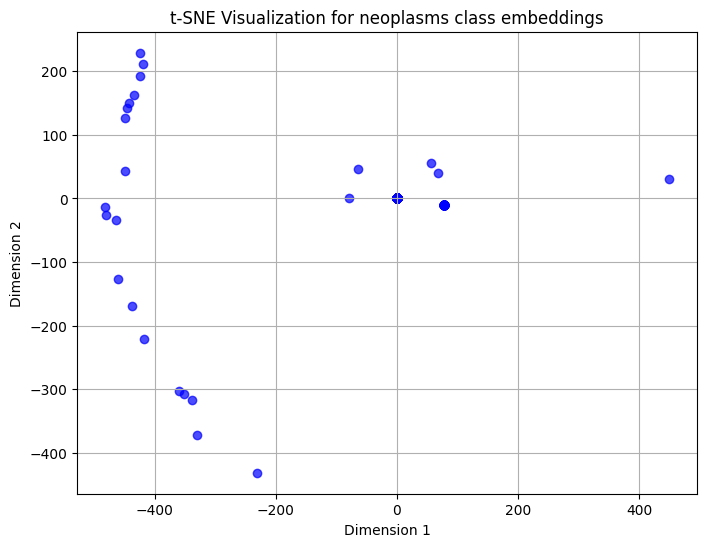

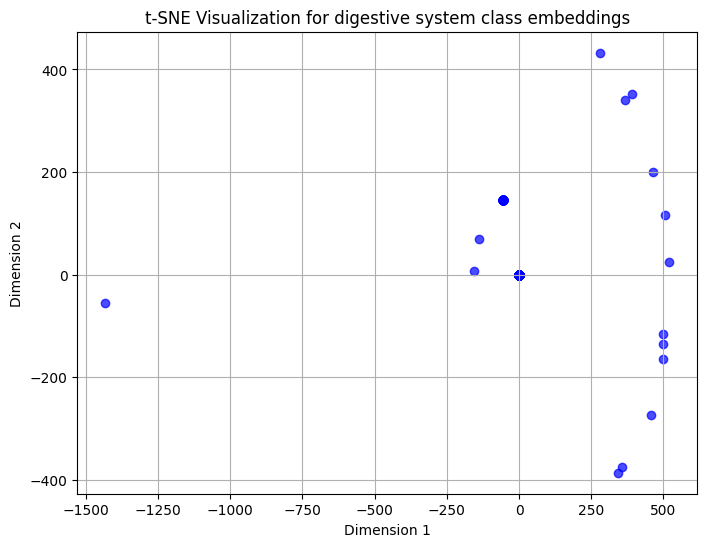

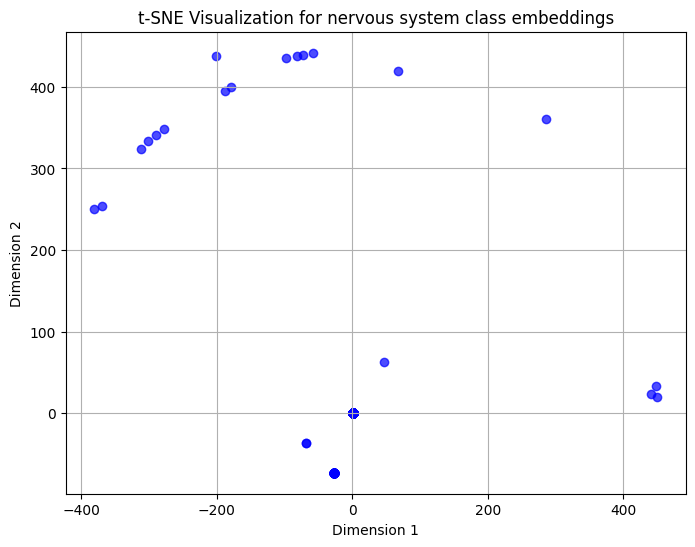

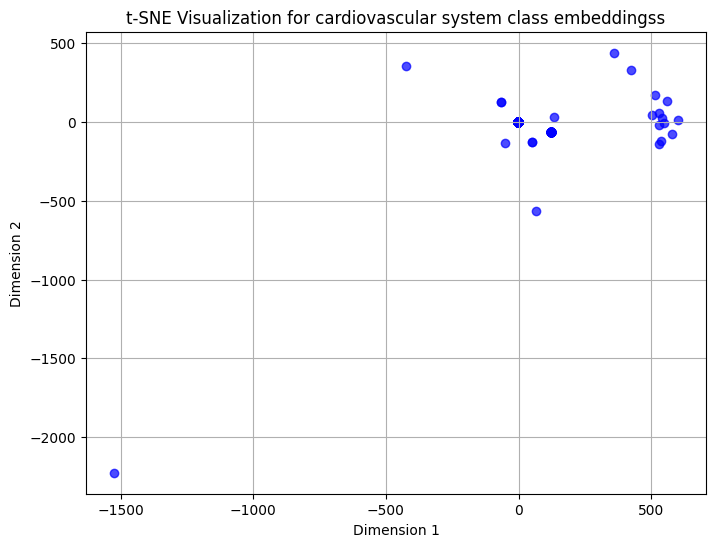

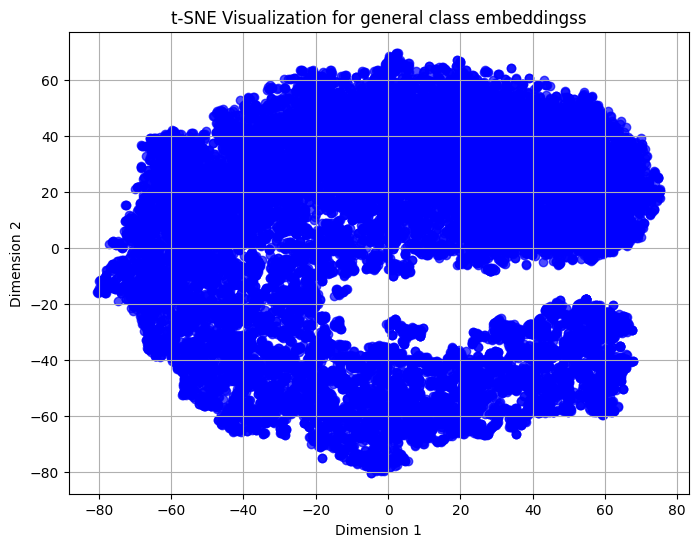

In [47]:
# Split dataset into classes and specific classes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

train_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_train.csv')
test_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_test.csv')


print(train_dataset.head())

neoplasms= train_dataset[train_dataset['condition_label'] == 1]
digestive_system = train_dataset[train_dataset['condition_label'] == 2]
nervous_system = train_dataset[train_dataset['condition_label'] == 3]
cardiovascular = train_dataset[train_dataset['condition_label'] == 4]
general = train_dataset[train_dataset['condition_label'] == 5]

print(general.head())
# Assuming you have lists of texts for the general class and specific classes
neoplasms_texts = neoplasms['medical_abstract']
digestive_texts = digestive_system['medical_abstract']
nervous_texts = nervous_system['medical_abstract']
cardiovascular_texts = cardiovascular['medical_abstract']
general_texts = general['medical_abstract']

neoplasms_train = preprocess(neoplasms)
digestive_train = preprocess(digestive_system)
nervous_train = preprocess(nervous_system)
cardiovascular_train = preprocess(cardiovascular)
general_train = preprocess(general)


# For general class
tokenizer = Tokenizer()
tokenizer.fit_on_texts(general_train)
general_train1 = tokenizer.texts_to_sequences(general_train)
vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
general_train1 = pad_sequences(general_train1, maxlen=max_length, padding='post')
general_w2v_model = Word2Vec(general_train, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embeddings for general and specific classes
general_embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in general_w2v_model.wv:
        general_embedding_matrix[i] = general_w2v_model.wv[word]
print(general_embedding_matrix.shape)
# Replace these steps with your Word2Vec model training process


## FOr neoplasm clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(neoplasms_train)
neoplasms_train1 = tokenizer.texts_to_sequences(neoplasms_train)
neoplasms_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
neoplasms_train1 = pad_sequences(neoplasms_train1, maxlen=max_length, padding='post')
neoplasms_w2v_model = Word2Vec(sentences=neoplasms_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
neoplasms_embedding_matrix = np.zeros((neoplasms_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in neoplasms_w2v_model.wv:
        neoplasms_embedding_matrix[i] = neoplasms_w2v_model.wv[word]
print(neoplasms_embedding_matrix.shape)


## FOr digestive clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(digestive_train)
digestive_train1 = tokenizer.texts_to_sequences(digestive_train)
digestive_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
digestive_train1 = pad_sequences(digestive_train1, maxlen=max_length, padding='post')
digestive_w2v_model = Word2Vec(sentences=digestive_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
digestive_embedding_matrix = np.zeros((digestive_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in digestive_w2v_model.wv:
        digestive_embedding_matrix[i] = digestive_w2v_model.wv[word]
print(digestive_embedding_matrix.shape)


## For nervous system clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(nervous_train)
nervous_train1 = tokenizer.texts_to_sequences(nervous_train)
nervous_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
nervous_train1 = pad_sequences(nervous_train1, maxlen=max_length, padding='post')
nervous_w2v_model = Word2Vec(sentences=nervous_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
nervous_embedding_matrix = np.zeros((nervous_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in nervous_w2v_model.wv:
        nervous_embedding_matrix[i] = nervous_w2v_model.wv[word]
print(nervous_embedding_matrix.shape)


## For cardiovascular clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cardiovascular_train)
cardiovascular_train1 = tokenizer.texts_to_sequences(cardiovascular_train)
cardiovascular_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
cardiovascular_train1 = pad_sequences(cardiovascular_train1, maxlen=max_length, padding='post')
cardiovascular_w2v_model = Word2Vec(sentences=cardiovascular_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
cardiovascular_embedding_matrix = np.zeros((cardiovascular_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in cardiovascular_w2v_model.wv:
        cardiovascular_embedding_matrix[i] = cardiovascular_w2v_model.wv[word]
print(cardiovascular_embedding_matrix.shape)



# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_neoplasms = tsne.fit_transform(neoplasms_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_digestive = tsne.fit_transform(digestive_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_nervous = tsne.fit_transform(nervous_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_cardiovascular = tsne.fit_transform(cardiovascular_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_general = tsne.fit_transform(general_embedding_matrix)


# Plotting
plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_neoplasms):
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for neoplasms class embeddings')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_digestive):
    label = 'digestive'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for digestive system class embeddings')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_nervous):
    label = 'neoplasms'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for nervous system class embeddings')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_cardiovascular):
    label = 'cardiovascular'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for cardiovascular system class embeddingss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_general):
    label = 'neoplasms'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for general class embeddingss')
plt.grid(True)
plt.show()

From the graphs executed above, it is clear to see a large variance/spread in distribution of the word embeddings in the general pathological category of our data, in comparison to the more conscise plots for the other classes.

Given t-SNE plots provide visualisations for the complex relationships between datapoints, the spread of the final class supports the  resulting low accuracy, due to more complex embedding structure that spreads between the other four categories.

### Analysis without the 'general pathological conditions' class

From research perfromed within our EDA, classification and t-SNE plot of the embeddings, it is clear to see that including the general pathological conditions category results in inaccuries within our classification as explored within class imbalance, lack of specifcity and spread of word embeddings within the class. Thus furhter analysis in this section is done without the use of the generic class, to explore model accuracy without the vaired class.

In [48]:
train_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_train.csv') #input own path
test_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_test.csv') # ""

train_dataset2 = train_dataset[train_dataset['condition_label'] != 5]
test_dataset2 = test_dataset[test_dataset['condition_label'] != 5]

In [49]:
text_train = train_dataset2['medical_abstract']
y_train = train_dataset2['condition_label']
text_test = test_dataset2['medical_abstract']
y_test = test_dataset2['condition_label']

In [50]:
X_trains  = preprocess(train_dataset2)
X_tests = preprocess(test_dataset2)
#print(X_trains[0])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_trains)

X_train = tokenizer.texts_to_sequences(X_trains)
X_test = tokenizer.texts_to_sequences(X_tests)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
#print(X_train[0])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


X_train_tensor = torch.LongTensor(X_train).to(device)
y_train_array = y_train.to_numpy()
y_train_tensor = torch.LongTensor(y_train_array).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)



X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

y_test_tensor = torch.LongTensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)
test_loader = test_loader

In [51]:
import random
torch.manual_seed(302)
np.random.seed(302)
random.seed(302)
# Train the Word2Vec model
vocab_size = len(tokenizer.word_index) + 1
w2v_model = Word2Vec(X_trains, vector_size=100, window=5, min_count=1, workers=4)
print(w2v_model)
#w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)


# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


Word2Vec<vocab=26234, vector_size=100, alpha=0.025>
(26235, 100)


In [52]:
num_classes =4
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)

class CNNMulticlass(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_length):
        super(CNNMulticlass, self).__init__()
        #Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False #keeps original embedding matrix

        #two convolutional layers and 2 max pool layers like paper[1]
        self.conv1 = nn.Conv1d(embedding_dim, 256, kernel_size=2)
        self.pool1 = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=2)
        self.pool2 = nn.MaxPool1d(5)
        #flattening for fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * ((max_length - 4) // 25) , 256)
        self.fc2 = nn.Linear(256, num_classes)
        #softmax activation for final output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      #pass input through embedding layer
        x = self.embedding(x)
        #need to rearrange for conv layer
        x = x.permute(0, 2, 1)
        #RelU activations with conv and max pool layers
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x




In [53]:
model_multiclass = CNNMulticlass(vocab_size, 100, embedding_matrix, max_length).to(device)
optimizer = torch.optim.Adam(model_multiclass.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


from tqdm.auto import tqdm
print(len(test_loader))
train_time_start_on_cpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n-----")
    train_loss = 0
    for batch, (inputs, labels) in enumerate(train_loader):
        model_multiclass.train()
        # Forward pass'=
        #print(inputs)
        y_pred = model_multiclass(inputs).to(device)
        #print(y_pred.softmax(dim=1))
        #Calculate loss
        labels = labels.long() -1
        #print(labels)
        loss = criterion(y_pred, labels)
        train_loss += loss
        #optimizer zero-grad
        optimizer.zero_grad()
        #loss backward
        loss.backward()
        #step
        optimizer.step()

    train_loss /= len(train_loader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_multiclass.eval()
    with torch.inference_mode():
        for X_test_tensor, y_test_tensor in test_loader:
            #forward pass
            test_pred = model_multiclass(X_test_tensor).to(device)
            #print(y_test_tensor -1)[0,4]
            #calculate loss
            y_test_tensor = y_test_tensor-1 #.Long()
            y_test_tensor = y_test_tensor.to(device)
            test_loss += criterion(test_pred, y_test_tensor)
            #calculate accuracy
            y_preds = test_pred.argmax(dim=1)
            #print(y_preds)
            test_acc += accuracy_fn(y_true = y_test_tensor, y_pred = y_preds)
        # Calculate the test loss average per batch
        test_loss /= len(test_loader)

        # Calculate the test acc average per batch
        test_acc /= len(test_loader)



    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    train_time_end_on_cpu = timer()
    total_train_time_model_multiclass = print_train_time(start = train_time_start_on_cpu,
                                              end = train_time_end_on_cpu,
                                              device=str(next(model_multiclass.parameters()).device))

61


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0
-----

Train loss: 0.9992 | Test loss: 0.8372, Test acc: 68.1279
Train time on cpu: 13.241 seconds
Epoch:1
-----

Train loss: 0.8012 | Test loss: 0.7964, Test acc: 71.5530
Train time on cpu: 26.340 seconds
Epoch:2
-----

Train loss: 0.7391 | Test loss: 0.7855, Test acc: 73.5290
Train time on cpu: 40.318 seconds
Epoch:3
-----

Train loss: 0.6984 | Test loss: 0.6988, Test acc: 76.2441
Train time on cpu: 56.085 seconds
Epoch:4
-----

Train loss: 0.6648 | Test loss: 0.6933, Test acc: 75.3513
Train time on cpu: 71.453 seconds
Epoch:5
-----

Train loss: 0.6528 | Test loss: 0.6851, Test acc: 76.1929
Train time on cpu: 86.815 seconds
Epoch:6
-----

Train loss: 0.6399 | Test loss: 0.6996, Test acc: 76.1929
Train time on cpu: 102.139 seconds
Epoch:7
-----

Train loss: 0.6318 | Test loss: 0.6746, Test acc: 76.3466
Train time on cpu: 117.583 seconds
Epoch:8
-----

Train loss: 0.6216 | Test loss: 0.6687, Test acc: 76.8882
Train time on cpu: 132.935 seconds
Epoch:9
-----

Train loss: 0.6191 

Making predictions...:   0%|          | 0/61 [00:00<?, ?it/s]

mlxtend version: 0.23.0
tensor([2, 0, 3,  ..., 3, 0, 3])
tensor([1, 0, 2,  ..., 3, 1, 2])


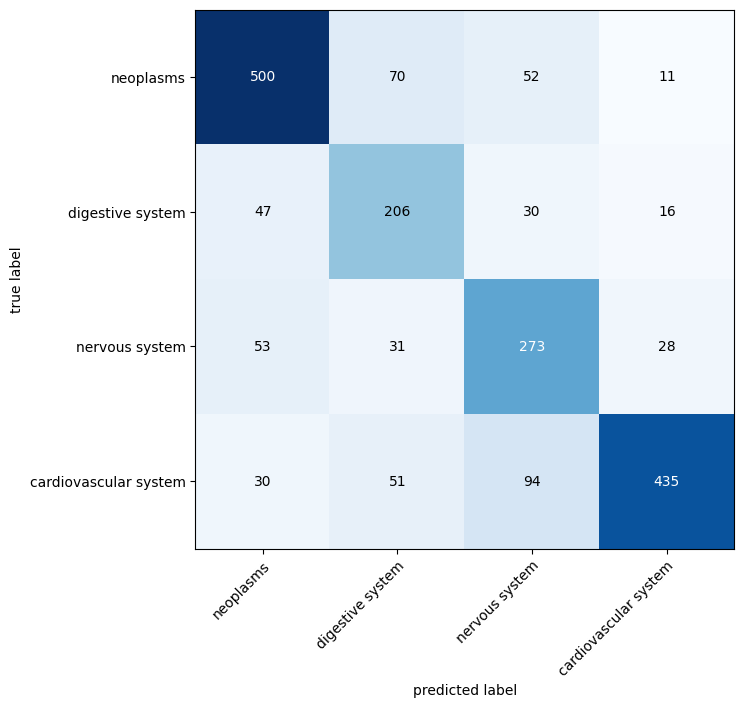

In [54]:
# Import tqdm.auto for progress bar tracking
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)

from tqdm.auto import tqdm

#1. Make predictions with trained model
y_preds = []
model_multiclass.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions..."):
    # Send the data and targets to target device
    # DO the forward pass
    X, y = X.to(device), y.to(device)

    y_logits = model_multiclass(X)
    #Turn prediction from logits -> prediction porbabilities -> prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim =0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

  #COncatenate list of predictions into a tensor
  #print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f" mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
class_names = ["neoplasms", "digestive system" , "nervous system", "cardiovascular system"]


confmat = ConfusionMatrix(task = "multiclass",
                          num_classes=4)

y_test_tensor = torch.LongTensor(y_test)-1
print(y_test_tensor)
print(y_pred_tensor)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test_tensor).numpy()

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor, #matplotlib likes working with numpy
    figsize=(10,7),
    class_names=class_names,
)



In [55]:
performance(confmat_tensor)

NEOPLASMS
Precision: 0.79, Recall: 0.79
DIGESTIVE SYSTEM DISEASES
Precision: 0.58, Recall: 0.69
NERVOUS SYSTEM DISEASES
Precision: 0.61, Recall: 0.71
CARDIOVASCULAR DISEASES
Precision: 0.89, Recall: 0.71
Total Accuracy: 0.734


From the improvement of accuracy for the updated confusion matrix it is clear to see our model successfully identifies patterns within medical abstracts attaining a successful classification rate of over 70%. However, while this is an improvement from the model including the general pathological conditions class, further grid searching for parameter and architectural exploration of our CNN should provide an even higher accuracy.